# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import optuna
import warnings

from collections import Counter
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix


warnings.filterwarnings("ignore")

# Model Pipeline

In [51]:
class CatBoostPipeline:
    """
    Class to preprocess the dataset and train the CatBoost model

    Attributes:
        train_df : DataFrame : Training DataFrame
        test_df : DataFrame : Test DataFrame
        categorical_features : List : Categorical features in the dataset
        numerical_features : List : Numerical features in the dataset
        model : CatBoostClassifier : Trained CatBoost model
        top_prop_categories : List : Top categories for 'proto' column
        top_service_categories : List : Top categories for 'service' column
        top_state_categories : List : Top categories for 'state' column
        corr_threshold : float : Correlation threshold for removing highly correlated features
        features_to_drop : List : Features to drop from the dataset

    Methods:
        basic_cleaning : Perform basic cleaning on the dataset
        identify_feature_types : Identify the feature types in the dataset
        handle_outliers : Handle outliers in the dataset
        convert_data_types : Convert the data types of the columns in the dataset
        selecting_categories : Select the top categories for the 'proto', 'service', and 'state' columns
        transform_categories : Transform the categories in the 'proto', 'service', and 'state' columns
        create_log1p_features : Create log1p features for the numerical columns in the dataset
        remove_highly_correlated_features : Remove highly correlated features from the dataset
        preprocess : Perform preprocessing on the dataset
        create_pool : Create a CatBoost Pool object
        train_model : Train the CatBoost model
        objective : Objective function for Optuna hyperparameter tuning
        optuna_tuning : Perform hyperparameter tuning using Optuna
        train_with_optuna : Train the CatBoost model with hyperparameter tuning using Optuna

    """
    def __init__(self, train_file_path, test_file_path):
        self.train_df = pd.read_parquet(train_file_path)
        self.test_df = pd.read_parquet(test_file_path)
        self.categorical_features = []
        self.numerical_features = []
        self.model = None
        self.top_prop_categories = None
        self.top_service_categories = None
        self.top_state_categories = None
        self.corr_threshold = 0.95
        self.features_to_drop = []  # Store features to drop

    def basic_cleaning(self, df):
        """
        Perform basic cleaning on the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            df :DataFrame : Cleaned DataFrame
        """
        columns_to_drop = ['swin', 'stcpb', 'dtcpb', 'dwin', 'label', 'is_sm_ips_ports', 'response_body_len', 'rate']
        df = df[~df['attack_cat'].isin(['Normal', 'Analysis', 'Shellcode', 'Worms', 'Backdoor'])]
        epsilon = 1e-10  # Small constant to avoid division by zero

        df["Speed of Operations to Speed of Data Bytes"] = np.log1p(df["sbytes"] / (df["dbytes"] + epsilon))
        df["Time for a Single Process"] = np.log1p(df["dur"] / (df["spkts"] + epsilon))
        df["Ratio of Data Flow"] = np.log1p(df["dbytes"] / (df["sbytes"] + epsilon))
        df["Ratio of Packet Flow"] = np.log1p(df["dpkts"] / (df["spkts"] + epsilon))
        df["Total Page Errors"] = np.log1p(df["dur"] * df["sloss"])
        df["Network Usage"] = np.log1p(df["sbytes"] + df["dbytes"])
        df["Network Activity Rate"] = np.log1p(df["spkts"] + df["dpkts"])
        df["Network Latency"] = np.log1p(df["spkts"] - df["dpkts"])
        
        return df.drop(columns=columns_to_drop, axis=1)

    def identify_feature_types(self, df):
        """
        Identify the feature types in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            None
        """
        self.categorical_features = df.select_dtypes(include=['category', 'object']).columns.tolist()
        self.numerical_features = df.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 'float32']).columns.tolist()
        self.categorical_features = [col for col in self.categorical_features if col != 'attack_cat']

    def handle_outliers(self, df):
        """
        Handle outliers in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with outliers handled
        """
        for column in self.numerical_features:
            lower_bound = df[column].quantile(0.001)
            upper_bound = df[column].quantile(0.999)
            df[column] = df[column].clip(lower_bound, upper_bound)
        return df

    def convert_data_types(self, df):
        """
        Convert the data types of the columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with converted data types
        """
        for column in self.categorical_features:
            df[column] = df[column].astype('category')
        for column in self.numerical_features:
            df[column] = df[column].astype('float32')
        return df

    def selecting_categories(self, df):
        """
        Select the top categories for the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            Tuple : Top categories for 'proto', 'service', and 'state' columns
        """
        top_prop_categories = df['proto'].value_counts().head(6).index
        top_service_categories = df['service'].value_counts().head(8).index
        top_state_categories = df['state'].value_counts().head(5).index
        return top_prop_categories, top_service_categories, top_state_categories

    def transform_categories(self, df, top_prop_categories, top_service_categories, top_state_categories):
        """
        Transform the categories in the 'proto', 'service', and 'state' columns

        Args:
            df : DataFrame : Input DataFrame
            top_prop_categories : List : Top categories for 'proto' column
            top_service_categories : List : Top categories for 'service' column
            top_state_categories : List : Top categories for 'state' column

        Returns:
            DataFrame : DataFrame with transformed categories
        """
        df['proto'] = np.where(df['proto'].isin(top_prop_categories), df['proto'], '-')
        df['service'] = np.where(df['service'].isin(top_service_categories), df['service'], '-')
        df['state'] = np.where(df['state'].isin(top_state_categories), df['state'], '-')
        return df

    def create_log1p_features(self, df):
        """
        Create log1p features for the numerical columns in the dataset

        Args:
            df : DataFrame : Input DataFrame

        Returns:
            DataFrame : DataFrame with log1p features
        """
        log_features = [
            'smean', 'dmean',
            'sinpkt', 'dinpkt', 'sload', 'dload', 'sbytes', 'dbytes',
            'sjit', 'djit',
        ]
        for feature in log_features:
            if feature in df.columns:
                df[feature] = np.log1p(df[feature])

        return df
    
    def remove_highly_correlated_features(self, df, is_train=True):
        """
        Remove highly correlated features from the dataset

        Args:
            df : DataFrame : Input DataFrame
            is_train : bool : Whether the dataset is the training set

        Returns:
            DataFrame : DataFrame with highly correlated features removed
        """
        if is_train:
            corr_matrix = df[self.numerical_features].corr().abs()  # Get the correlation matrix of numerical features
            upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

            # Find features that have a correlation greater than the threshold
            self.features_to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > self.corr_threshold)]
            print(f"Removing highly correlated features in training: {self.features_to_drop}")
        else:
            print(f"Removing same highly correlated features in test: {self.features_to_drop}")
        
        # Drop the highly correlated features (based on train set) from the dataframe
        df = df.drop(columns=self.features_to_drop, axis=1)

        # Update the numerical features list after dropping the highly correlated features
        self.numerical_features = [col for col in self.numerical_features if col not in self.features_to_drop]
        return df


    def preprocess(self, is_train=True):
        """
        Perform preprocessing on the dataset

        Args:
            is_train : bool : Whether the dataset is the training set

        Returns:
            Tuple : X, y
        """
        # Get the DataFrame based on whether it is the training set or not
        df = self.train_df if is_train else self.test_df

        # Basic cleaning
        df = self.basic_cleaning(df)

        # Identify feature types
        self.identify_feature_types(df)

        # Handle outliers
        df = self.handle_outliers(df) if is_train else df

        # Select top categories
        self.top_prop_categories, self.top_service_categories, self.top_state_categories = self.selecting_categories(df) if is_train else (self.top_prop_categories, self.top_service_categories, self.top_state_categories)

        # Transform categories
        df = self.transform_categories(df, self.top_prop_categories, self.top_service_categories, self.top_state_categories)
        
        # Log1p Feature Creation
        df = self.create_log1p_features(df)

        # Remove highly correlated features (use same features for both train and test)
        df = self.remove_highly_correlated_features(df, is_train=is_train)

        # Convert data types
        df = self.convert_data_types(df)
        
        # Separate features and target
        X = df.drop('attack_cat', axis=1)
        y = df['attack_cat']

        return X, y

    def create_pool(self, X, y=None):
        """
        Create a CatBoost Pool object

        Args:
            X : DataFrame : Input DataFrame
            y : DataFrame : Target DataFrame

        Returns:
            Pool : CatBoost Pool object
        """
        return Pool(
            data=X,
            label=y,
            cat_features=self.categorical_features
        )

    def calculate_class_weights(self, y):
        """
        Calculate class weights for multi-class classification based on class frequencies.

        Args:
            y : Series : Target labels

        Returns:
            dict : Class weights dictionary where keys are class indices and values are weights
        """
        class_counts = Counter(y)
        total_samples = len(y)
        class_weights = {class_idx: total_samples / count for class_idx, count in class_counts.items()}
        return class_weights

    def train_model(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the CatBoost model for multi-class classification.

        Args:
            X_train : DataFrame : Training features
            y_train : Series : Training target
            X_val : DataFrame : Validation features (optional)
            y_val : Series : Validation target (optional)

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        train_pool = self.create_pool(X_train, y_train)
        val_pool = self.create_pool(X_val, y_val) if X_val is not None else None

        # Calculate multi-class weights
        class_weights = self.calculate_class_weights(y_train)

        model = CatBoostClassifier(
            iterations=1000,
            learning_rate=0.1,
            depth=6,
            loss_function='MultiClass',
            eval_metric='MultiClass',
            task_type='GPU',
            random_seed=17,
            class_weights=class_weights,  # Apply class weights for multi-class
            verbose=100
        )

        model.fit(
            train_pool,
            eval_set=val_pool,
            verbose=100
        )

        return model

    def objective(self, trial, X_train, y_train, X_val, y_val):
        """
        Objective function for Optuna hyperparameter tuning for multi-class classification.

        Args:
            trial : Trial : Optuna trial object
            X_train : DataFrame : Training features
            y_train : Series : Training target
            X_val : DataFrame : Validation features
            y_val : Series : Validation target

        Returns:
            float : MultiClass F1 score
        """
        try:
            # Define the hyperparameters to be tuned
            params = {
                'iterations': trial.suggest_int('iterations', 800, 1200),
                'learning_rate': trial.suggest_float('learning_rate', 9e-2, 2e-1),
                'depth': trial.suggest_int('depth', 4, 8),
                'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-1, 1.0),
                'random_seed': 17,
                'loss_function': 'MultiClass',
                'eval_metric': 'MultiClass',
                'task_type': 'GPU',
                'class_weights': self.calculate_class_weights(y_train),  # Apply multi-class weights
            }

            train_pool = self.create_pool(X_train, y_train)
            val_pool = self.create_pool(X_val, y_val)

            model = CatBoostClassifier(**params)
            model.fit(train_pool, eval_set=val_pool, verbose=100, early_stopping_rounds=100)

            predictions = model.predict(val_pool)

            # Return the validation F1 score
            val_score = f1_score(y_val, predictions, average='weighted')
            return val_score

        except Exception as e:
            print(f"Error in objective function: {e}")
            return 0.0  # Return a default score in case of error

    def optuna_tuning(self, X_train, y_train, X_val, y_val, n_trials=50):
        """
        Perform hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            Dict : Best hyperparameters
        """
        try:
            study = optuna.create_study(direction='maximize')
            study.optimize(lambda trial: self.objective(trial, X_train, y_train, X_val, y_val), n_trials=n_trials)

            # Print and return the best parameters found by Optuna
            print("Best hyperparameters: ", study.best_params)
            print("Best F1: ", study.best_value)

            return study.best_params

        except Exception as e:
            print(f"Error in Optuna tuning: {e}")
            return None  # Return None if tuning fails

    def train_with_optuna(self, X_train, y_train, X_val, y_val,tune = True, n_trials=50):
        """
        Train the CatBoost model with hyperparameter tuning using Optuna

        Args:
            X_train : DataFrame : Training features
            y_train : DataFrame : Training target
            X_val : DataFrame : Validation features
            y_val : DataFrame : Validation target
            n_trials : int : Number of Optuna trials

        Returns:
            CatBoostClassifier : Trained CatBoost model
        """
        try:
            if(tune):
                # Tune hyperparameters
                best_params = self.optuna_tuning(X_train, y_train, X_val, y_val, n_trials)

                if best_params is None:
                    print("Optuna tuning failed. Exiting training process.")
                    return None  # Exit if tuning failed
            else:
                best_params = {'iterations': 414, 'learning_rate': 0.23033131775971566, 'depth': 9, 'l2_leaf_reg': 2.656726559140494}
            # Train the model with the best hyperparameters
            train_pool = self.create_pool(X_train, y_train)
            val_pool = self.create_pool(X_val, y_val)

            fixed_params = {
                'class_weights': self.calculate_class_weights(y_train),  # Apply multi-class weights
                'loss_function': 'MultiClass',
                'eval_metric': 'MultiClass',
                'random_seed': 17,
                'task_type': 'GPU',
                'verbose': 100,
            }
            model = CatBoostClassifier(
                **best_params,
                **fixed_params
            )

            model.fit(
                train_pool,
                eval_set=val_pool,
            )

            return model

        except Exception as e:
            print(f"Error during training with Optuna: {e}")
            return None  # Return None if training fails


In [5]:
# Define the paths to the training and testing datasets
train_path = '/kaggle/input/unswnb15/UNSW_NB15_training-set.parquet'
test_path = '/kaggle/input/unswnb15/UNSW_NB15_testing-set.parquet'

In [52]:
# Usage example
pipeline = CatBoostPipeline(train_path, test_path)

# Preprocess training data
X_train, y_train = pipeline.preprocess(is_train=True)
X_test, y_test = pipeline.preprocess(is_train=False)

# Split into training and validation sets
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=17)

Removing highly correlated features in training: ['dload', 'sjit', 'synack', 'ackdat', 'dmean', 'ct_ftp_cmd']
Removing same highly correlated features in test: ['dload', 'sjit', 'synack', 'ackdat', 'dmean', 'ct_ftp_cmd']


In [47]:
# Train baseline model
model = pipeline.train_model(X_train, y_train, X_val, y_val)

0:	learn: 1.4167243	test: 1.4509222	best: 1.4509222 (0)	total: 13ms	remaining: 13s
100:	learn: 0.5024640	test: 0.5321180	best: 0.5321180 (100)	total: 1.01s	remaining: 8.98s
200:	learn: 0.4794296	test: 0.5125289	best: 0.5125289 (200)	total: 2.03s	remaining: 8.06s
300:	learn: 0.4694036	test: 0.5074142	best: 0.5074142 (300)	total: 3.17s	remaining: 7.37s
400:	learn: 0.4617337	test: 0.5041615	best: 0.5041615 (400)	total: 4.23s	remaining: 6.33s
500:	learn: 0.4553621	test: 0.5017790	best: 0.5017255 (490)	total: 5.2s	remaining: 5.18s
600:	learn: 0.4508366	test: 0.5006494	best: 0.5006130 (598)	total: 6.21s	remaining: 4.12s
700:	learn: 0.4470190	test: 0.5003512	best: 0.4999470 (622)	total: 7.18s	remaining: 3.06s
800:	learn: 0.4437896	test: 0.5007030	best: 0.4999470 (622)	total: 8.16s	remaining: 2.03s
900:	learn: 0.4408311	test: 0.5005666	best: 0.4999470 (622)	total: 9.13s	remaining: 1s
999:	learn: 0.4385216	test: 0.5004051	best: 0.4999470 (622)	total: 10.1s	remaining: 0us
bestTest = 0.4999469984

In [48]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.8333143222732924
Precision: 0.866696652055265
Recall: 0.8216723940435281


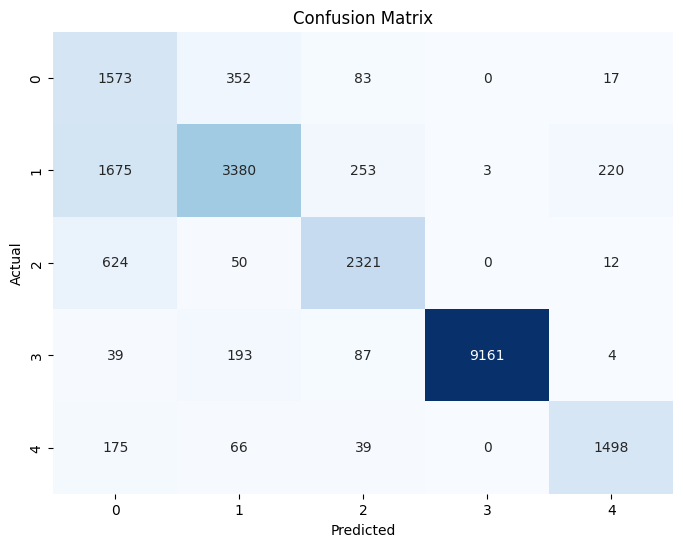

In [49]:
# Compute metrics for multi-class classification
f1 = f1_score(y_test, predictions, average='weighted')  # Macro average for multi-class
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [50]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, predictions)
# Display the report
print(report)

                precision    recall  f1-score   support

           DoS       0.38      0.78      0.51      2025
      Exploits       0.84      0.61      0.71      5531
       Fuzzers       0.83      0.77      0.80      3007
       Generic       1.00      0.97      0.98      9484
Reconnaissance       0.86      0.84      0.85      1778

      accuracy                           0.82     21825
     macro avg       0.78      0.79      0.77     21825
  weighted avg       0.87      0.82      0.83     21825



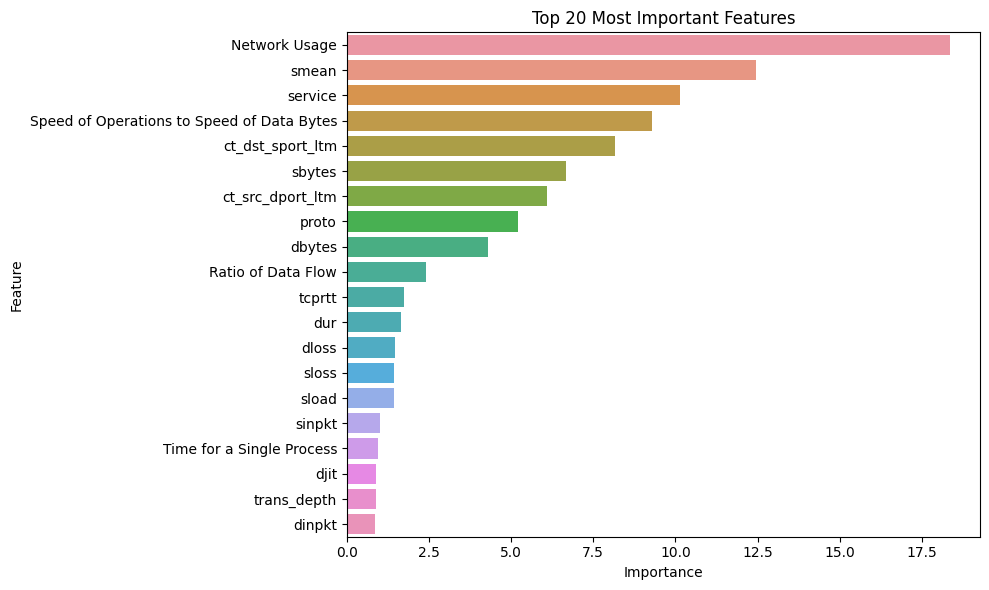

In [53]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()

In [54]:
# Train the model with hyperparameter tuning
model = pipeline.train_with_optuna(X_train, y_train, X_val, y_val, tune=True, n_trials=50)

[I 2024-11-05 16:26:25,051] A new study created in memory with name: no-name-64b92840-23e3-4a08-98f1-e0b3e1f5de38


0:	learn: 1.3676617	test: 1.4162349	best: 1.4162349 (0)	total: 7.82ms	remaining: 8.47s
100:	learn: 0.5135145	test: 0.5405928	best: 0.5405928 (100)	total: 656ms	remaining: 6.38s
200:	learn: 0.4907238	test: 0.5182365	best: 0.5182365 (200)	total: 1.3s	remaining: 5.73s
300:	learn: 0.4809059	test: 0.5108960	best: 0.5108960 (300)	total: 1.94s	remaining: 5.04s
400:	learn: 0.4736858	test: 0.5077405	best: 0.5077405 (400)	total: 2.57s	remaining: 4.38s
500:	learn: 0.4675789	test: 0.5044402	best: 0.5044402 (500)	total: 3.22s	remaining: 3.75s
600:	learn: 0.4635152	test: 0.5035575	best: 0.5034405 (557)	total: 3.88s	remaining: 3.12s
700:	learn: 0.4602602	test: 0.5033424	best: 0.5026971 (679)	total: 4.55s	remaining: 2.49s
bestTest = 0.5026971392
bestIteration = 679
Shrink model to first 680 iterations.


[I 2024-11-05 16:26:30,950] Trial 0 finished with value: 0.8336727276397661 and parameters: {'iterations': 1084, 'learning_rate': 0.1557392896964902, 'depth': 4, 'l2_leaf_reg': 0.2582434002902523}. Best is trial 0 with value: 0.8336727276397661.


0:	learn: 1.3697025	test: 1.4130789	best: 1.4130789 (0)	total: 11.1ms	remaining: 13.1s
100:	learn: 0.4931722	test: 0.5232782	best: 0.5232782 (100)	total: 1s	remaining: 10.7s
200:	learn: 0.4706143	test: 0.5070299	best: 0.5070299 (200)	total: 1.95s	remaining: 9.47s
300:	learn: 0.4604549	test: 0.5034049	best: 0.5034049 (300)	total: 2.96s	remaining: 8.59s
400:	learn: 0.4523642	test: 0.5009187	best: 0.5008686 (399)	total: 3.92s	remaining: 7.56s
500:	learn: 0.4460825	test: 0.5001713	best: 0.5001713 (500)	total: 4.88s	remaining: 6.57s
600:	learn: 0.4415869	test: 0.5001355	best: 0.4997243 (588)	total: 5.86s	remaining: 5.59s
bestTest = 0.499724278
bestIteration = 588
Shrink model to first 589 iterations.


[I 2024-11-05 16:26:38,597] Trial 1 finished with value: 0.8343584491536467 and parameters: {'iterations': 1175, 'learning_rate': 0.12639872229177948, 'depth': 6, 'l2_leaf_reg': 0.581185119143048}. Best is trial 1 with value: 0.8343584491536467.


0:	learn: 1.2724959	test: 1.3362652	best: 1.3362652 (0)	total: 12.3ms	remaining: 9.82s
100:	learn: 0.4805479	test: 0.5160795	best: 0.5160795 (100)	total: 995ms	remaining: 6.9s
200:	learn: 0.4603262	test: 0.5066349	best: 0.5066349 (200)	total: 1.96s	remaining: 5.86s
300:	learn: 0.4509256	test: 0.5054821	best: 0.5052851 (272)	total: 2.93s	remaining: 4.86s
400:	learn: 0.4434773	test: 0.5044435	best: 0.5042608 (354)	total: 3.9s	remaining: 3.89s
500:	learn: 0.4380981	test: 0.5050949	best: 0.5042587 (426)	total: 4.91s	remaining: 2.94s
bestTest = 0.5042586806
bestIteration = 426
Shrink model to first 427 iterations.


[I 2024-11-05 16:26:44,687] Trial 2 finished with value: 0.8345844595786017 and parameters: {'iterations': 801, 'learning_rate': 0.18471977367684683, 'depth': 6, 'l2_leaf_reg': 0.728826168245973}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.4479095	test: 1.4765540	best: 1.4765540 (0)	total: 11.2ms	remaining: 10.1s
100:	learn: 0.5188908	test: 0.5452641	best: 0.5452641 (100)	total: 780ms	remaining: 6.19s
200:	learn: 0.4920961	test: 0.5198091	best: 0.5198091 (200)	total: 1.53s	remaining: 5.34s
300:	learn: 0.4808359	test: 0.5120676	best: 0.5120676 (300)	total: 2.28s	remaining: 4.54s
400:	learn: 0.4726735	test: 0.5072219	best: 0.5072219 (400)	total: 3.05s	remaining: 3.81s
500:	learn: 0.4658406	test: 0.5041434	best: 0.5041076 (498)	total: 3.8s	remaining: 3.04s
600:	learn: 0.4615705	test: 0.5026694	best: 0.5026208 (596)	total: 4.56s	remaining: 2.28s
700:	learn: 0.4580099	test: 0.5016303	best: 0.5016303 (700)	total: 5.31s	remaining: 1.52s
800:	learn: 0.4548105	test: 0.5010040	best: 0.5010040 (800)	total: 6.08s	remaining: 766ms
900:	learn: 0.4519655	test: 0.5011750	best: 0.5009574 (802)	total: 6.83s	remaining: 7.58ms
901:	learn: 0.4519460	test: 0.5011547	best: 0.5009574 (802)	total: 6.84s	remaining: 0us
bestTest = 0.50

[I 2024-11-05 16:26:52,493] Trial 3 finished with value: 0.833957104330555 and parameters: {'iterations': 902, 'learning_rate': 0.09005546686445162, 'depth': 5, 'l2_leaf_reg': 0.14689860373614197}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.3438506	test: 1.3924399	best: 1.3924399 (0)	total: 11.2ms	remaining: 12.3s
100:	learn: 0.4891237	test: 0.5189207	best: 0.5189207 (100)	total: 1.01s	remaining: 9.96s
200:	learn: 0.4682463	test: 0.5064503	best: 0.5061670 (190)	total: 1.99s	remaining: 8.89s
300:	learn: 0.4580642	test: 0.5039661	best: 0.5039661 (300)	total: 2.97s	remaining: 7.87s
400:	learn: 0.4508376	test: 0.5021818	best: 0.5021818 (400)	total: 3.95s	remaining: 6.87s
500:	learn: 0.4447018	test: 0.5013661	best: 0.5013395 (499)	total: 4.94s	remaining: 5.89s
600:	learn: 0.4402161	test: 0.5012364	best: 0.5011687 (552)	total: 5.95s	remaining: 4.92s
700:	learn: 0.4363753	test: 0.5007713	best: 0.5005271 (664)	total: 6.94s	remaining: 3.93s
bestTest = 0.5005270633
bestIteration = 664
Shrink model to first 665 iterations.


[I 2024-11-05 16:27:01,027] Trial 4 finished with value: 0.8345179748539557 and parameters: {'iterations': 1098, 'learning_rate': 0.1413961945513454, 'depth': 6, 'l2_leaf_reg': 0.9003961329014889}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.3573593	test: 1.3727901	best: 1.3727901 (0)	total: 21ms	remaining: 23.6s
100:	learn: 0.4758827	test: 0.5126232	best: 0.5126232 (100)	total: 1.86s	remaining: 18.9s
200:	learn: 0.4540665	test: 0.5026931	best: 0.5025400 (198)	total: 3.72s	remaining: 17.1s
300:	learn: 0.4420439	test: 0.5025274	best: 0.5019524 (235)	total: 5.54s	remaining: 15.2s
bestTest = 0.5019523906
bestIteration = 235
Shrink model to first 236 iterations.


[I 2024-11-05 16:27:08,119] Trial 5 finished with value: 0.8333281821053901 and parameters: {'iterations': 1126, 'learning_rate': 0.11990297342904613, 'depth': 8, 'l2_leaf_reg': 0.9640873161610056}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.3097727	test: 1.3281514	best: 1.3281514 (0)	total: 19.4ms	remaining: 19.2s
100:	learn: 0.4692622	test: 0.5102890	best: 0.5102890 (100)	total: 1.85s	remaining: 16.3s
200:	learn: 0.4485598	test: 0.5033087	best: 0.5032685 (192)	total: 3.64s	remaining: 14.3s
300:	learn: 0.4366433	test: 0.5053739	best: 0.5031891 (205)	total: 5.49s	remaining: 12.6s
bestTest = 0.5031891078
bestIteration = 205
Shrink model to first 206 iterations.


[I 2024-11-05 16:27:14,617] Trial 6 finished with value: 0.8338232741250301 and parameters: {'iterations': 991, 'learning_rate': 0.14485981217297803, 'depth': 8, 'l2_leaf_reg': 0.8257468932137167}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.3963699	test: 1.4344985	best: 1.4344985 (0)	total: 12.2ms	remaining: 13.7s
100:	learn: 0.4980485	test: 0.5281132	best: 0.5281132 (100)	total: 975ms	remaining: 9.88s
200:	learn: 0.4761289	test: 0.5122945	best: 0.5122945 (200)	total: 1.93s	remaining: 8.88s
300:	learn: 0.4646595	test: 0.5068693	best: 0.5068577 (283)	total: 2.9s	remaining: 7.95s
400:	learn: 0.4566479	test: 0.5038268	best: 0.5038268 (400)	total: 3.88s	remaining: 7s
500:	learn: 0.4503104	test: 0.5022155	best: 0.5021897 (499)	total: 4.85s	remaining: 6.04s
600:	learn: 0.4456582	test: 0.5017732	best: 0.5013618 (597)	total: 5.82s	remaining: 5.07s
bestTest = 0.5013617632
bestIteration = 597
Shrink model to first 598 iterations.


[I 2024-11-05 16:27:22,346] Trial 7 finished with value: 0.8341164685398581 and parameters: {'iterations': 1125, 'learning_rate': 0.11128571751136962, 'depth': 6, 'l2_leaf_reg': 0.8781205101362396}. Best is trial 2 with value: 0.8345844595786017.


0:	learn: 1.3185485	test: 1.3726444	best: 1.3726444 (0)	total: 10.4ms	remaining: 10.9s
100:	learn: 0.4947064	test: 0.5232634	best: 0.5232634 (100)	total: 808ms	remaining: 7.59s
200:	learn: 0.4747582	test: 0.5101235	best: 0.5100142 (198)	total: 1.59s	remaining: 6.7s
300:	learn: 0.4646332	test: 0.5071798	best: 0.5070429 (276)	total: 2.35s	remaining: 5.85s
400:	learn: 0.4574243	test: 0.5062671	best: 0.5061303 (396)	total: 3.12s	remaining: 5.05s
500:	learn: 0.4510551	test: 0.5051736	best: 0.5048525 (468)	total: 3.88s	remaining: 4.25s
600:	learn: 0.4469161	test: 0.5041495	best: 0.5038611 (588)	total: 4.65s	remaining: 3.47s
700:	learn: 0.4432375	test: 0.5040932	best: 0.5035973 (665)	total: 5.41s	remaining: 2.69s
bestTest = 0.5035972961
bestIteration = 665
Shrink model to first 666 iterations.


[I 2024-11-05 16:27:29,221] Trial 8 finished with value: 0.8347679010022812 and parameters: {'iterations': 1049, 'learning_rate': 0.17073806132818614, 'depth': 5, 'l2_leaf_reg': 0.2679592619207868}. Best is trial 8 with value: 0.8347679010022812.


0:	learn: 1.3603938	test: 1.4056296	best: 1.4056296 (0)	total: 11.2ms	remaining: 10s
100:	learn: 0.4933973	test: 0.5195143	best: 0.5195143 (100)	total: 981ms	remaining: 7.74s
200:	learn: 0.4722277	test: 0.5055086	best: 0.5055086 (200)	total: 1.94s	remaining: 6.74s
300:	learn: 0.4609860	test: 0.5012426	best: 0.5012426 (300)	total: 2.91s	remaining: 5.77s
400:	learn: 0.4526778	test: 0.5004278	best: 0.5002104 (374)	total: 4.02s	remaining: 4.98s
500:	learn: 0.4467517	test: 0.4993291	best: 0.4993291 (500)	total: 5.01s	remaining: 3.97s
600:	learn: 0.4419622	test: 0.4992354	best: 0.4988967 (589)	total: 5.97s	remaining: 2.95s
700:	learn: 0.4383657	test: 0.4992668	best: 0.4987787 (665)	total: 6.94s	remaining: 1.95s
bestTest = 0.4987786911
bestIteration = 665
Shrink model to first 666 iterations.


[I 2024-11-05 16:27:37,747] Trial 9 finished with value: 0.8358541945458405 and parameters: {'iterations': 898, 'learning_rate': 0.13176590175042874, 'depth': 6, 'l2_leaf_reg': 0.9301003592089477}. Best is trial 9 with value: 0.8358541945458405.


0:	learn: 1.4247444	test: 1.4340091	best: 1.4340091 (0)	total: 15.5ms	remaining: 14.1s
100:	learn: 0.4937297	test: 0.5237243	best: 0.5237243 (100)	total: 1.29s	remaining: 10.3s
200:	learn: 0.4696425	test: 0.5076934	best: 0.5076934 (200)	total: 2.57s	remaining: 9.05s
300:	learn: 0.4579850	test: 0.5037677	best: 0.5037677 (300)	total: 3.85s	remaining: 7.77s
400:	learn: 0.4494622	test: 0.5019510	best: 0.5019510 (400)	total: 5.13s	remaining: 6.48s
500:	learn: 0.4435215	test: 0.5010472	best: 0.5010430 (499)	total: 6.43s	remaining: 5.22s
600:	learn: 0.4388261	test: 0.5016473	best: 0.5009501 (520)	total: 7.71s	remaining: 3.94s
bestTest = 0.5009501299
bestIteration = 520
Shrink model to first 521 iterations.


[I 2024-11-05 16:27:46,701] Trial 10 finished with value: 0.8352507344543295 and parameters: {'iterations': 908, 'learning_rate': 0.09010400453299507, 'depth': 7, 'l2_leaf_reg': 0.5064718694293531}. Best is trial 9 with value: 0.8358541945458405.


0:	learn: 1.4232705	test: 1.4326078	best: 1.4326078 (0)	total: 15.7ms	remaining: 14.3s
100:	learn: 0.4934100	test: 0.5242845	best: 0.5242845 (100)	total: 1.31s	remaining: 10.6s
200:	learn: 0.4695900	test: 0.5078069	best: 0.5078069 (200)	total: 2.58s	remaining: 9.21s
300:	learn: 0.4589082	test: 0.5045127	best: 0.5044469 (291)	total: 3.86s	remaining: 7.89s
400:	learn: 0.4502896	test: 0.5021561	best: 0.5021097 (399)	total: 5.13s	remaining: 6.6s
500:	learn: 0.4436008	test: 0.5001852	best: 0.5001400 (499)	total: 6.44s	remaining: 5.34s
bestTest = 0.50014
bestIteration = 499
Shrink model to first 500 iterations.


[I 2024-11-05 16:27:55,535] Trial 11 finished with value: 0.8362308727314894 and parameters: {'iterations': 917, 'learning_rate': 0.09086447256789787, 'depth': 7, 'l2_leaf_reg': 0.4937441061154346}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.2293798	test: 1.2481703	best: 1.2481703 (0)	total: 14.4ms	remaining: 13.1s
100:	learn: 0.4677840	test: 0.5095665	best: 0.5091322 (90)	total: 1.28s	remaining: 10.3s
200:	learn: 0.4478627	test: 0.5047684	best: 0.5037305 (170)	total: 2.56s	remaining: 9.03s
300:	learn: 0.4363805	test: 0.5054390	best: 0.5033603 (240)	total: 3.83s	remaining: 7.76s
bestTest = 0.5033602652
bestIteration = 240
Shrink model to first 241 iterations.


[I 2024-11-05 16:28:00,674] Trial 12 finished with value: 0.8328559949923171 and parameters: {'iterations': 911, 'learning_rate': 0.1993182281615572, 'depth': 7, 'l2_leaf_reg': 0.5142992263771666}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3976998	test: 1.4083044	best: 1.4083044 (0)	total: 15.5ms	remaining: 12.9s
100:	learn: 0.4890682	test: 0.5214511	best: 0.5214511 (100)	total: 1.29s	remaining: 9.39s
200:	learn: 0.4663705	test: 0.5058425	best: 0.5058425 (200)	total: 2.59s	remaining: 8.19s
300:	learn: 0.4547672	test: 0.5035722	best: 0.5032829 (283)	total: 3.85s	remaining: 6.85s
400:	learn: 0.4466434	test: 0.5025584	best: 0.5025584 (400)	total: 5.16s	remaining: 5.59s
500:	learn: 0.4407004	test: 0.5022714	best: 0.5022225 (499)	total: 6.46s	remaining: 4.32s
600:	learn: 0.4357939	test: 0.5023730	best: 0.5020130 (550)	total: 7.73s	remaining: 3.02s
bestTest = 0.5020130396
bestIteration = 550
Shrink model to first 551 iterations.


[I 2024-11-05 16:28:10,010] Trial 13 finished with value: 0.8337563204517529 and parameters: {'iterations': 836, 'learning_rate': 0.10418858847935579, 'depth': 7, 'l2_leaf_reg': 0.6532458038735957}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3480779	test: 1.3611301	best: 1.3611301 (0)	total: 15.5ms	remaining: 15.1s
100:	learn: 0.4810172	test: 0.5165363	best: 0.5165065 (99)	total: 1.28s	remaining: 11.1s
200:	learn: 0.4598861	test: 0.5063761	best: 0.5063761 (200)	total: 2.55s	remaining: 9.82s
300:	learn: 0.4490574	test: 0.5059257	best: 0.5057807 (295)	total: 3.86s	remaining: 8.65s
400:	learn: 0.4410878	test: 0.5049743	best: 0.5048255 (347)	total: 5.15s	remaining: 7.38s
500:	learn: 0.4347398	test: 0.5051353	best: 0.5044137 (427)	total: 6.44s	remaining: 6.11s
bestTest = 0.5044137483
bestIteration = 427
Shrink model to first 428 iterations.


[I 2024-11-05 16:28:17,778] Trial 14 finished with value: 0.8340733427537799 and parameters: {'iterations': 976, 'learning_rate': 0.1307683019559469, 'depth': 7, 'l2_leaf_reg': 0.40568626011770526}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3363344	test: 1.3867518	best: 1.3867518 (0)	total: 10.1ms	remaining: 9.59s
100:	learn: 0.4967300	test: 0.5246916	best: 0.5246916 (100)	total: 777ms	remaining: 6.53s
200:	learn: 0.4764555	test: 0.5104627	best: 0.5104627 (200)	total: 1.54s	remaining: 5.75s
300:	learn: 0.4668668	test: 0.5054767	best: 0.5054588 (276)	total: 2.29s	remaining: 4.94s
400:	learn: 0.4594367	test: 0.5045740	best: 0.5045660 (396)	total: 3.06s	remaining: 4.19s
500:	learn: 0.4537452	test: 0.5027931	best: 0.5027931 (500)	total: 3.82s	remaining: 3.42s
600:	learn: 0.4494130	test: 0.5015970	best: 0.5012587 (593)	total: 4.59s	remaining: 2.67s
700:	learn: 0.4457531	test: 0.5008871	best: 0.5005682 (663)	total: 5.4s	remaining: 1.92s
800:	learn: 0.4427849	test: 0.5009250	best: 0.5005310 (741)	total: 6.21s	remaining: 1.16s
bestTest = 0.5005309627
bestIteration = 741
Shrink model to first 742 iterations.


[I 2024-11-05 16:28:25,286] Trial 15 finished with value: 0.8346308490390753 and parameters: {'iterations': 950, 'learning_rate': 0.15904508751212465, 'depth': 5, 'l2_leaf_reg': 0.7332541544519897}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3894650	test: 1.4029187	best: 1.4029187 (0)	total: 19.1ms	remaining: 16.5s
100:	learn: 0.4797113	test: 0.5135014	best: 0.5135014 (100)	total: 1.81s	remaining: 13.7s
200:	learn: 0.4568898	test: 0.5022136	best: 0.5018218 (191)	total: 3.62s	remaining: 11.9s
300:	learn: 0.4453641	test: 0.5019477	best: 0.5016918 (235)	total: 5.44s	remaining: 10.2s
400:	learn: 0.4367208	test: 0.5028672	best: 0.5015572 (309)	total: 7.25s	remaining: 8.38s
bestTest = 0.5015572256
bestIteration = 309
Shrink model to first 310 iterations.


[I 2024-11-05 16:28:33,623] Trial 16 finished with value: 0.8347299852790274 and parameters: {'iterations': 865, 'learning_rate': 0.10354734677655388, 'depth': 8, 'l2_leaf_reg': 0.42490416985284385}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3959489	test: 1.4383446	best: 1.4383446 (0)	total: 7.84ms	remaining: 8.16s
100:	learn: 0.5186449	test: 0.5462615	best: 0.5462615 (100)	total: 695ms	remaining: 6.47s
200:	learn: 0.4944363	test: 0.5237555	best: 0.5237555 (200)	total: 1.32s	remaining: 5.51s
300:	learn: 0.4842565	test: 0.5165443	best: 0.5165443 (300)	total: 1.99s	remaining: 4.89s
400:	learn: 0.4767845	test: 0.5125181	best: 0.5125181 (400)	total: 2.65s	remaining: 4.24s
500:	learn: 0.4711059	test: 0.5092940	best: 0.5092940 (500)	total: 3.33s	remaining: 3.6s
600:	learn: 0.4671092	test: 0.5074590	best: 0.5073704 (592)	total: 4s	remaining: 2.94s
700:	learn: 0.4637903	test: 0.5069441	best: 0.5066737 (677)	total: 4.66s	remaining: 2.27s
800:	learn: 0.4606967	test: 0.5059882	best: 0.5059229 (798)	total: 5.29s	remaining: 1.59s
900:	learn: 0.4580516	test: 0.5048302	best: 0.5047684 (899)	total: 5.96s	remaining: 932ms
1000:	learn: 0.4560287	test: 0.5051735	best: 0.5045413 (912)	total: 6.6s	remaining: 270ms
bestTest = 0.5045

[I 2024-11-05 16:28:41,290] Trial 17 finished with value: 0.8332945141280685 and parameters: {'iterations': 1042, 'learning_rate': 0.13574441546872512, 'depth': 4, 'l2_leaf_reg': 0.38466065526056165}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3782316	test: 1.3897949	best: 1.3897949 (0)	total: 14.2ms	remaining: 13.4s
100:	learn: 0.4866063	test: 0.5192603	best: 0.5192603 (100)	total: 1.29s	remaining: 10.9s
200:	learn: 0.4644746	test: 0.5037725	best: 0.5036651 (199)	total: 2.59s	remaining: 9.67s
300:	learn: 0.4533341	test: 0.5008101	best: 0.5007827 (295)	total: 3.85s	remaining: 8.31s
400:	learn: 0.4452158	test: 0.5008790	best: 0.5003056 (330)	total: 5.16s	remaining: 7.07s
bestTest = 0.5003055544
bestIteration = 330
Shrink model to first 331 iterations.


[I 2024-11-05 16:28:47,728] Trial 18 finished with value: 0.8330971863624904 and parameters: {'iterations': 951, 'learning_rate': 0.11450959172174971, 'depth': 7, 'l2_leaf_reg': 0.9924015129945102}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3325507	test: 1.3837449	best: 1.3837449 (0)	total: 10.4ms	remaining: 8.98s
100:	learn: 0.4969822	test: 0.5238739	best: 0.5238739 (100)	total: 947ms	remaining: 7.16s
200:	learn: 0.4756327	test: 0.5089808	best: 0.5089808 (200)	total: 1.72s	remaining: 5.68s
300:	learn: 0.4658102	test: 0.5053160	best: 0.5053160 (300)	total: 2.5s	remaining: 4.69s
400:	learn: 0.4584949	test: 0.5041082	best: 0.5040926 (399)	total: 3.27s	remaining: 3.78s
500:	learn: 0.4527022	test: 0.5027235	best: 0.5027235 (500)	total: 4.05s	remaining: 2.94s
600:	learn: 0.4485672	test: 0.5018616	best: 0.5016702 (589)	total: 4.81s	remaining: 2.11s
700:	learn: 0.4449867	test: 0.5016435	best: 0.5015787 (671)	total: 5.63s	remaining: 1.32s
800:	learn: 0.4420279	test: 0.5020068	best: 0.5013564 (740)	total: 6.39s	remaining: 511ms
bestTest = 0.5013564252
bestIteration = 740
Shrink model to first 741 iterations.


[I 2024-11-05 16:28:55,456] Trial 19 finished with value: 0.8346781926901321 and parameters: {'iterations': 865, 'learning_rate': 0.16151391393904213, 'depth': 5, 'l2_leaf_reg': 0.6314308313036697}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4039121	test: 1.4142074	best: 1.4142074 (0)	total: 15.2ms	remaining: 14.1s
100:	learn: 0.4904028	test: 0.5211803	best: 0.5211803 (100)	total: 1.31s	remaining: 10.8s
200:	learn: 0.4683069	test: 0.5056394	best: 0.5056394 (200)	total: 2.6s	remaining: 9.45s
300:	learn: 0.4565541	test: 0.5013023	best: 0.5013023 (300)	total: 3.86s	remaining: 8.11s
400:	learn: 0.4482428	test: 0.5001647	best: 0.5001647 (400)	total: 5.17s	remaining: 6.85s
500:	learn: 0.4415116	test: 0.4994221	best: 0.4992042 (498)	total: 6.46s	remaining: 5.57s
bestTest = 0.4992041806
bestIteration = 498
Shrink model to first 499 iterations.


[I 2024-11-05 16:29:04,198] Trial 20 finished with value: 0.8353424779390626 and parameters: {'iterations': 933, 'learning_rate': 0.10093415908262054, 'depth': 7, 'l2_leaf_reg': 0.7876250628239104}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4112160	test: 1.4211499	best: 1.4211499 (0)	total: 15.5ms	remaining: 14.5s
100:	learn: 0.4920472	test: 0.5224869	best: 0.5224869 (100)	total: 1.3s	remaining: 10.7s
200:	learn: 0.4680418	test: 0.5047374	best: 0.5047374 (200)	total: 2.56s	remaining: 9.37s
300:	learn: 0.4568510	test: 0.5023341	best: 0.5023341 (300)	total: 3.83s	remaining: 8.07s
400:	learn: 0.4488204	test: 0.5017424	best: 0.5012818 (358)	total: 5.12s	remaining: 6.82s
bestTest = 0.5012818065
bestIteration = 358
Shrink model to first 359 iterations.


[I 2024-11-05 16:29:11,000] Trial 21 finished with value: 0.834250024602483 and parameters: {'iterations': 935, 'learning_rate': 0.097120824664278, 'depth': 7, 'l2_leaf_reg': 0.7624360554831164}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4120552	test: 1.4471588	best: 1.4471588 (0)	total: 11.9ms	remaining: 10.5s
100:	learn: 0.5001361	test: 0.5277090	best: 0.5277090 (100)	total: 995ms	remaining: 7.65s
200:	learn: 0.4767802	test: 0.5105363	best: 0.5105363 (200)	total: 1.96s	remaining: 6.61s
300:	learn: 0.4658414	test: 0.5051128	best: 0.5051128 (300)	total: 2.96s	remaining: 5.68s
400:	learn: 0.4582001	test: 0.5023658	best: 0.5023658 (400)	total: 3.93s	remaining: 4.68s
500:	learn: 0.4516989	test: 0.5002844	best: 0.5002844 (500)	total: 4.92s	remaining: 3.7s
600:	learn: 0.4470155	test: 0.4994086	best: 0.4991886 (588)	total: 5.89s	remaining: 2.71s
bestTest = 0.4991886208
bestIteration = 588
Shrink model to first 589 iterations.


[I 2024-11-05 16:29:18,697] Trial 22 finished with value: 0.8350131149834039 and parameters: {'iterations': 878, 'learning_rate': 0.10254029629374897, 'depth': 6, 'l2_leaf_reg': 0.8102455967567845}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3582822	test: 1.3736571	best: 1.3736571 (0)	total: 20.9ms	remaining: 21.1s
100:	learn: 0.4754463	test: 0.5115479	best: 0.5115479 (100)	total: 1.82s	remaining: 16.4s
200:	learn: 0.4526969	test: 0.5041845	best: 0.5038104 (191)	total: 3.63s	remaining: 14.6s
300:	learn: 0.4410491	test: 0.5030137	best: 0.5023372 (261)	total: 5.49s	remaining: 13s
bestTest = 0.5023371824
bestIteration = 261
Shrink model to first 262 iterations.


[I 2024-11-05 16:29:26,212] Trial 23 finished with value: 0.8341417322732715 and parameters: {'iterations': 1012, 'learning_rate': 0.1194249935486858, 'depth': 8, 'l2_leaf_reg': 0.9016375768245721}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4219225	test: 1.4551446	best: 1.4551446 (0)	total: 12.3ms	remaining: 10.1s
100:	learn: 0.5024014	test: 0.5308802	best: 0.5308802 (100)	total: 983ms	remaining: 6.97s
200:	learn: 0.4788390	test: 0.5123568	best: 0.5123568 (200)	total: 1.96s	remaining: 6.01s
300:	learn: 0.4675311	test: 0.5062504	best: 0.5062504 (300)	total: 2.92s	remaining: 5s
400:	learn: 0.4592615	test: 0.5033854	best: 0.5033151 (392)	total: 3.88s	remaining: 4.02s
500:	learn: 0.4528729	test: 0.5012718	best: 0.5010529 (487)	total: 4.85s	remaining: 3.06s
600:	learn: 0.4483100	test: 0.5008372	best: 0.5004663 (587)	total: 5.82s	remaining: 2.09s
700:	learn: 0.4444315	test: 0.4997457	best: 0.4997457 (700)	total: 6.8s	remaining: 1.13s
800:	learn: 0.4411149	test: 0.5002604	best: 0.4997355 (710)	total: 7.82s	remaining: 156ms
bestTest = 0.499735484
bestIteration = 710
Shrink model to first 711 iterations.


[I 2024-11-05 16:29:35,097] Trial 24 finished with value: 0.8341597902101304 and parameters: {'iterations': 817, 'learning_rate': 0.09709057739691665, 'depth': 6, 'l2_leaf_reg': 0.6577093077781633}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3589329	test: 1.3714499	best: 1.3714499 (0)	total: 13.8ms	remaining: 12.8s
100:	learn: 0.4827646	test: 0.5157733	best: 0.5157729 (99)	total: 1.29s	remaining: 10.6s
200:	learn: 0.4596055	test: 0.5034432	best: 0.5034432 (200)	total: 2.56s	remaining: 9.29s
300:	learn: 0.4489333	test: 0.5032818	best: 0.5027914 (249)	total: 3.82s	remaining: 8.01s
400:	learn: 0.4405609	test: 0.5027046	best: 0.5026284 (354)	total: 5.08s	remaining: 6.73s
500:	learn: 0.4351547	test: 0.5029522	best: 0.5025562 (405)	total: 6.35s	remaining: 5.47s
bestTest = 0.5025562306
bestIteration = 405
Shrink model to first 406 iterations.


[I 2024-11-05 16:29:42,432] Trial 25 finished with value: 0.8353494656854286 and parameters: {'iterations': 932, 'learning_rate': 0.12486876447211044, 'depth': 7, 'l2_leaf_reg': 0.5621775037282556}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3135988	test: 1.3283377	best: 1.3283377 (0)	total: 13.9ms	remaining: 13.6s
100:	learn: 0.4756894	test: 0.5122097	best: 0.5122097 (100)	total: 1.31s	remaining: 11.3s
200:	learn: 0.4552258	test: 0.5042594	best: 0.5042594 (200)	total: 2.56s	remaining: 9.88s
300:	learn: 0.4437606	test: 0.5036622	best: 0.5024986 (241)	total: 3.82s	remaining: 8.56s
bestTest = 0.5024986102
bestIteration = 241
Shrink model to first 242 iterations.


[I 2024-11-05 16:29:47,684] Trial 26 finished with value: 0.8324542796393626 and parameters: {'iterations': 976, 'learning_rate': 0.14988577153880003, 'depth': 7, 'l2_leaf_reg': 0.3155038352933841}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3459398	test: 1.3620814	best: 1.3620814 (0)	total: 19.2ms	remaining: 16s
100:	learn: 0.4723815	test: 0.5125512	best: 0.5125512 (100)	total: 1.84s	remaining: 13.4s
200:	learn: 0.4510050	test: 0.5042193	best: 0.5038435 (177)	total: 3.64s	remaining: 11.5s
bestTest = 0.5038434886
bestIteration = 177
Shrink model to first 178 iterations.


[I 2024-11-05 16:29:53,676] Trial 27 finished with value: 0.8342804771326009 and parameters: {'iterations': 837, 'learning_rate': 0.12578366512665876, 'depth': 8, 'l2_leaf_reg': 0.4714735027399999}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3376620	test: 1.3512289	best: 1.3512289 (0)	total: 15.5ms	remaining: 13.7s
100:	learn: 0.4787864	test: 0.5137039	best: 0.5137039 (100)	total: 1.29s	remaining: 10s
200:	learn: 0.4569325	test: 0.5047043	best: 0.5045383 (198)	total: 2.56s	remaining: 8.71s
300:	learn: 0.4462243	test: 0.5043400	best: 0.5037640 (253)	total: 3.82s	remaining: 7.43s
400:	learn: 0.4375111	test: 0.5044988	best: 0.5035175 (339)	total: 5.1s	remaining: 6.17s
bestTest = 0.5035174908
bestIteration = 339
Shrink model to first 340 iterations.


[I 2024-11-05 16:30:00,197] Trial 28 finished with value: 0.8327131822408381 and parameters: {'iterations': 886, 'learning_rate': 0.13647223930114002, 'depth': 7, 'l2_leaf_reg': 0.10519182224941537}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3727009	test: 1.4201618	best: 1.4201618 (0)	total: 7.83ms	remaining: 6.63s
100:	learn: 0.5145538	test: 0.5407980	best: 0.5407980 (100)	total: 665ms	remaining: 4.91s
200:	learn: 0.4903218	test: 0.5179020	best: 0.5179020 (200)	total: 1.28s	remaining: 4.13s
300:	learn: 0.4808092	test: 0.5095467	best: 0.5095467 (300)	total: 1.92s	remaining: 3.48s
400:	learn: 0.4735422	test: 0.5065884	best: 0.5065884 (400)	total: 2.56s	remaining: 2.85s
500:	learn: 0.4675113	test: 0.5030509	best: 0.5030509 (500)	total: 3.26s	remaining: 2.25s
600:	learn: 0.4636900	test: 0.5017414	best: 0.5017414 (600)	total: 3.91s	remaining: 1.6s
700:	learn: 0.4606716	test: 0.5005851	best: 0.5005851 (700)	total: 4.55s	remaining: 947ms
800:	learn: 0.4576971	test: 0.5004750	best: 0.4998966 (722)	total: 5.24s	remaining: 301ms
bestTest = 0.499896609
bestIteration = 722
Shrink model to first 723 iterations.


[I 2024-11-05 16:30:06,549] Trial 29 finished with value: 0.8328521949094396 and parameters: {'iterations': 847, 'learning_rate': 0.1521352554385103, 'depth': 4, 'l2_leaf_reg': 0.5785150559755787}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3010173	test: 1.3585780	best: 1.3585780 (0)	total: 12.1ms	remaining: 12.3s
100:	learn: 0.4842689	test: 0.5160296	best: 0.5160296 (100)	total: 985ms	remaining: 8.95s
200:	learn: 0.4635611	test: 0.5078573	best: 0.5078228 (199)	total: 1.96s	remaining: 7.96s
300:	learn: 0.4529123	test: 0.5053122	best: 0.5052217 (293)	total: 2.92s	remaining: 6.96s
400:	learn: 0.4445744	test: 0.5042254	best: 0.5042254 (400)	total: 3.91s	remaining: 6.01s
500:	learn: 0.4391659	test: 0.5055386	best: 0.5042009 (407)	total: 4.89s	remaining: 5.05s
bestTest = 0.5042009089
bestIteration = 407
Shrink model to first 408 iterations.


[I 2024-11-05 16:30:12,440] Trial 30 finished with value: 0.8336853672432041 and parameters: {'iterations': 1018, 'learning_rate': 0.16700759904677542, 'depth': 6, 'l2_leaf_reg': 0.1888021873572449}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3858765	test: 1.3970627	best: 1.3970627 (0)	total: 16.1ms	remaining: 14.8s
100:	learn: 0.4872074	test: 0.5191257	best: 0.5191257 (100)	total: 1.34s	remaining: 10.8s
200:	learn: 0.4660967	test: 0.5053513	best: 0.5053513 (200)	total: 2.6s	remaining: 9.29s
300:	learn: 0.4547052	test: 0.5040528	best: 0.5040528 (300)	total: 3.89s	remaining: 7.98s
400:	learn: 0.4461093	test: 0.5019259	best: 0.5019216 (399)	total: 5.19s	remaining: 6.69s
500:	learn: 0.4400292	test: 0.5021458	best: 0.5017600 (407)	total: 6.48s	remaining: 5.39s
bestTest = 0.5017599568
bestIteration = 407
Shrink model to first 408 iterations.


[I 2024-11-05 16:30:19,946] Trial 31 finished with value: 0.8342032308324073 and parameters: {'iterations': 918, 'learning_rate': 0.11044131037774335, 'depth': 7, 'l2_leaf_reg': 0.9391702593236397}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3715596	test: 1.4145642	best: 1.4145642 (0)	total: 11ms	remaining: 10.3s
100:	learn: 0.4930880	test: 0.5230878	best: 0.5230878 (100)	total: 978ms	remaining: 8.1s
200:	learn: 0.4717249	test: 0.5078626	best: 0.5078626 (200)	total: 1.94s	remaining: 7.12s
300:	learn: 0.4614698	test: 0.5036123	best: 0.5036123 (300)	total: 2.92s	remaining: 6.16s
400:	learn: 0.4536746	test: 0.5010127	best: 0.5010127 (400)	total: 3.92s	remaining: 5.23s
500:	learn: 0.4476458	test: 0.4993159	best: 0.4992362 (497)	total: 4.89s	remaining: 4.26s
600:	learn: 0.4430041	test: 0.4997068	best: 0.4991891 (517)	total: 5.86s	remaining: 3.27s
bestTest = 0.499189113
bestIteration = 517
Shrink model to first 518 iterations.


[I 2024-11-05 16:30:26,906] Trial 32 finished with value: 0.8348290170728454 and parameters: {'iterations': 937, 'learning_rate': 0.12534149156997884, 'depth': 6, 'l2_leaf_reg': 0.825051592488253}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3731598	test: 1.3849790	best: 1.3849790 (0)	total: 15.4ms	remaining: 14.7s
100:	learn: 0.4838758	test: 0.5180193	best: 0.5180193 (100)	total: 1.3s	remaining: 11s
200:	learn: 0.4620190	test: 0.5060663	best: 0.5060663 (200)	total: 2.56s	remaining: 9.68s
300:	learn: 0.4504897	test: 0.5040150	best: 0.5040150 (300)	total: 3.85s	remaining: 8.43s
400:	learn: 0.4422873	test: 0.5026163	best: 0.5026090 (399)	total: 5.14s	remaining: 7.17s
500:	learn: 0.4358015	test: 0.5033397	best: 0.5023656 (423)	total: 6.46s	remaining: 5.92s
bestTest = 0.502365614
bestIteration = 423
Shrink model to first 424 iterations.


[I 2024-11-05 16:30:34,607] Trial 33 finished with value: 0.8336378860469799 and parameters: {'iterations': 960, 'learning_rate': 0.11719828282568782, 'depth': 7, 'l2_leaf_reg': 0.3406355969761989}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4223257	test: 1.4554720	best: 1.4554720 (0)	total: 11.3ms	remaining: 10.5s
100:	learn: 0.5022244	test: 0.5323554	best: 0.5323554 (100)	total: 988ms	remaining: 8.08s
200:	learn: 0.4787255	test: 0.5124580	best: 0.5124580 (200)	total: 1.95s	remaining: 7.03s
300:	learn: 0.4681226	test: 0.5070210	best: 0.5070210 (300)	total: 2.91s	remaining: 6.04s
400:	learn: 0.4600824	test: 0.5040123	best: 0.5040123 (400)	total: 3.88s	remaining: 5.08s
500:	learn: 0.4528935	test: 0.5019414	best: 0.5019414 (500)	total: 4.86s	remaining: 4.13s
600:	learn: 0.4482770	test: 0.5010642	best: 0.5009067 (589)	total: 5.82s	remaining: 3.15s
700:	learn: 0.4443849	test: 0.5009175	best: 0.5006481 (670)	total: 6.79s	remaining: 2.19s
bestTest = 0.5006481342
bestIteration = 670
Shrink model to first 671 iterations.


[I 2024-11-05 16:30:43,049] Trial 34 finished with value: 0.8338374927951036 and parameters: {'iterations': 927, 'learning_rate': 0.09686809255478539, 'depth': 6, 'l2_leaf_reg': 0.6170439331510735}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3937885	test: 1.4045864	best: 1.4045864 (0)	total: 15.4ms	remaining: 13.7s
100:	learn: 0.4881806	test: 0.5187116	best: 0.5187116 (100)	total: 1.32s	remaining: 10.3s
200:	learn: 0.4662485	test: 0.5049990	best: 0.5049990 (200)	total: 2.59s	remaining: 8.84s
300:	learn: 0.4544232	test: 0.5025887	best: 0.5025210 (293)	total: 3.86s	remaining: 7.5s
400:	learn: 0.4466505	test: 0.5006824	best: 0.5006824 (400)	total: 5.14s	remaining: 6.21s
500:	learn: 0.4405134	test: 0.5002066	best: 0.5000878 (488)	total: 6.42s	remaining: 4.93s
600:	learn: 0.4354920	test: 0.5007704	best: 0.4999971 (521)	total: 7.7s	remaining: 3.65s
bestTest = 0.4999970849
bestIteration = 521
Shrink model to first 522 iterations.


[I 2024-11-05 16:30:51,994] Trial 35 finished with value: 0.8359268414371973 and parameters: {'iterations': 886, 'learning_rate': 0.10624890074941185, 'depth': 7, 'l2_leaf_reg': 0.7036364768263037}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3793643	test: 1.3934397	best: 1.3934397 (0)	total: 19.9ms	remaining: 17.7s
100:	learn: 0.4783614	test: 0.5144635	best: 0.5144635 (100)	total: 1.84s	remaining: 14.4s
200:	learn: 0.4559581	test: 0.5045213	best: 0.5045213 (200)	total: 3.64s	remaining: 12.5s
300:	learn: 0.4440622	test: 0.5058470	best: 0.5042917 (213)	total: 5.45s	remaining: 10.7s
bestTest = 0.5042916552
bestIteration = 213
Shrink model to first 214 iterations.


[I 2024-11-05 16:30:58,574] Trial 36 finished with value: 0.8349108165663611 and parameters: {'iterations': 891, 'learning_rate': 0.10864925405448936, 'depth': 8, 'l2_leaf_reg': 0.5524901314321694}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3797429	test: 1.4214436	best: 1.4214436 (0)	total: 8.98ms	remaining: 7.85s
100:	learn: 0.5048320	test: 0.5328622	best: 0.5328622 (100)	total: 761ms	remaining: 5.83s
200:	learn: 0.4829164	test: 0.5143665	best: 0.5143665 (200)	total: 1.51s	remaining: 5.08s
300:	learn: 0.4720795	test: 0.5103291	best: 0.5103291 (300)	total: 2.26s	remaining: 4.31s
400:	learn: 0.4642621	test: 0.5069217	best: 0.5069217 (400)	total: 3s	remaining: 3.55s
500:	learn: 0.4579240	test: 0.5037810	best: 0.5036840 (493)	total: 3.85s	remaining: 2.88s
600:	learn: 0.4536057	test: 0.5031047	best: 0.5029448 (589)	total: 4.78s	remaining: 2.18s
700:	learn: 0.4503025	test: 0.5025757	best: 0.5025284 (655)	total: 5.6s	remaining: 1.39s
800:	learn: 0.4468724	test: 0.5020320	best: 0.5015444 (740)	total: 6.39s	remaining: 590ms
bestTest = 0.5015443538
bestIteration = 740
Shrink model to first 741 iterations.


[I 2024-11-05 16:31:06,263] Trial 37 finished with value: 0.8344319109068263 and parameters: {'iterations': 875, 'learning_rate': 0.13136638755738794, 'depth': 5, 'l2_leaf_reg': 0.6937438075215749}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3763851	test: 1.4184363	best: 1.4184363 (0)	total: 12ms	remaining: 9.63s
100:	learn: 0.4929949	test: 0.5226981	best: 0.5226981 (100)	total: 969ms	remaining: 6.74s
200:	learn: 0.4714219	test: 0.5086233	best: 0.5086233 (200)	total: 1.93s	remaining: 5.8s
300:	learn: 0.4612032	test: 0.5044432	best: 0.5044432 (300)	total: 2.89s	remaining: 4.83s
400:	learn: 0.4531732	test: 0.5035514	best: 0.5035298 (399)	total: 3.85s	remaining: 3.87s
500:	learn: 0.4473159	test: 0.5027424	best: 0.5027159 (499)	total: 4.84s	remaining: 2.92s
600:	learn: 0.4422382	test: 0.5024641	best: 0.5022261 (546)	total: 5.8s	remaining: 1.96s
bestTest = 0.502226144
bestIteration = 546
Shrink model to first 547 iterations.


[I 2024-11-05 16:31:13,424] Trial 38 finished with value: 0.8338644564029478 and parameters: {'iterations': 804, 'learning_rate': 0.12257514574900158, 'depth': 6, 'l2_leaf_reg': 0.4576302170012767}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4165497	test: 1.4283332	best: 1.4283332 (0)	total: 19.2ms	remaining: 18.6s
100:	learn: 0.4851915	test: 0.5188140	best: 0.5188140 (100)	total: 1.82s	remaining: 15.7s
200:	learn: 0.4611888	test: 0.5053278	best: 0.5053278 (200)	total: 3.63s	remaining: 14s
300:	learn: 0.4492809	test: 0.5040959	best: 0.5040893 (299)	total: 5.47s	remaining: 12.2s
400:	learn: 0.4407654	test: 0.5036561	best: 0.5032417 (341)	total: 7.29s	remaining: 10.4s
bestTest = 0.5032416552
bestIteration = 341
Shrink model to first 342 iterations.


[I 2024-11-05 16:31:22,430] Trial 39 finished with value: 0.8341696158578197 and parameters: {'iterations': 974, 'learning_rate': 0.09006611557764864, 'depth': 8, 'l2_leaf_reg': 0.6916490880532523}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3437438	test: 1.3923588	best: 1.3923588 (0)	total: 12.4ms	remaining: 11.1s
100:	learn: 0.4895433	test: 0.5170458	best: 0.5170458 (100)	total: 1.02s	remaining: 8.04s
200:	learn: 0.4682637	test: 0.5059702	best: 0.5059702 (200)	total: 1.98s	remaining: 6.85s
300:	learn: 0.4577619	test: 0.5022305	best: 0.5022305 (300)	total: 2.96s	remaining: 5.86s
400:	learn: 0.4493300	test: 0.5011141	best: 0.5010570 (399)	total: 3.94s	remaining: 4.86s
500:	learn: 0.4433738	test: 0.5005075	best: 0.5004782 (499)	total: 4.91s	remaining: 3.87s
600:	learn: 0.4388599	test: 0.5005733	best: 0.5002178 (513)	total: 5.88s	remaining: 2.88s
bestTest = 0.5002178367
bestIteration = 513
Shrink model to first 514 iterations.


[I 2024-11-05 16:31:29,358] Trial 40 finished with value: 0.8344140910048367 and parameters: {'iterations': 896, 'learning_rate': 0.141448476039019, 'depth': 6, 'l2_leaf_reg': 0.5279489914235542}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3927566	test: 1.4036036	best: 1.4036036 (0)	total: 13.9ms	remaining: 16.4s
100:	learn: 0.4882844	test: 0.5187952	best: 0.5187952 (100)	total: 1.29s	remaining: 13.8s
200:	learn: 0.4664052	test: 0.5053710	best: 0.5053710 (200)	total: 2.56s	remaining: 12.5s
300:	learn: 0.4551319	test: 0.5015337	best: 0.5014943 (299)	total: 3.89s	remaining: 11.4s
400:	learn: 0.4464052	test: 0.4996164	best: 0.4996164 (400)	total: 5.3s	remaining: 10.3s
500:	learn: 0.4408544	test: 0.4994136	best: 0.4993362 (477)	total: 6.67s	remaining: 9.05s
600:	learn: 0.4361495	test: 0.5011446	best: 0.4992236 (532)	total: 7.95s	remaining: 7.67s
bestTest = 0.4992236019
bestIteration = 532
Shrink model to first 533 iterations.


[I 2024-11-05 16:31:38,673] Trial 41 finished with value: 0.8358586769458346 and parameters: {'iterations': 1181, 'learning_rate': 0.10679880708841455, 'depth': 7, 'l2_leaf_reg': 0.8639208186151228}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3878462	test: 1.3989367	best: 1.3989367 (0)	total: 15.6ms	remaining: 17.3s
100:	learn: 0.4869463	test: 0.5173082	best: 0.5173082 (100)	total: 1.3s	remaining: 13s
200:	learn: 0.4654096	test: 0.5034751	best: 0.5034751 (200)	total: 2.56s	remaining: 11.6s
300:	learn: 0.4537928	test: 0.5006558	best: 0.5006558 (300)	total: 3.84s	remaining: 10.4s
400:	learn: 0.4457524	test: 0.5002672	best: 0.5002672 (400)	total: 5.15s	remaining: 9.17s
500:	learn: 0.4396803	test: 0.5009661	best: 0.4999536 (423)	total: 6.43s	remaining: 7.88s
bestTest = 0.4999536236
bestIteration = 423
Shrink model to first 424 iterations.


[I 2024-11-05 16:31:46,316] Trial 42 finished with value: 0.8351825437858611 and parameters: {'iterations': 1115, 'learning_rate': 0.10939435216025262, 'depth': 7, 'l2_leaf_reg': 0.8670059422279329}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3477936	test: 1.3608540	best: 1.3608540 (0)	total: 15.9ms	remaining: 19s
100:	learn: 0.4814764	test: 0.5167347	best: 0.5167347 (100)	total: 1.29s	remaining: 14s
200:	learn: 0.4595264	test: 0.5061404	best: 0.5061404 (200)	total: 2.58s	remaining: 12.7s
300:	learn: 0.4490395	test: 0.5051904	best: 0.5051904 (300)	total: 3.84s	remaining: 11.4s
400:	learn: 0.4413370	test: 0.5052129	best: 0.5047191 (335)	total: 5.12s	remaining: 10.1s
bestTest = 0.5047190755
bestIteration = 335
Shrink model to first 336 iterations.


[I 2024-11-05 16:31:52,801] Trial 43 finished with value: 0.8333377747415023 and parameters: {'iterations': 1194, 'learning_rate': 0.1309440407477109, 'depth': 7, 'l2_leaf_reg': 0.9202113096756354}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3754192	test: 1.3871222	best: 1.3871222 (0)	total: 15.6ms	remaining: 16.6s
100:	learn: 0.4862443	test: 0.5184766	best: 0.5184766 (100)	total: 1.32s	remaining: 12.7s
200:	learn: 0.4639423	test: 0.5058711	best: 0.5058711 (200)	total: 2.6s	remaining: 11.2s
300:	learn: 0.4530764	test: 0.5031811	best: 0.5026487 (299)	total: 3.87s	remaining: 9.85s
400:	learn: 0.4448232	test: 0.5025543	best: 0.5025543 (400)	total: 5.14s	remaining: 8.54s
500:	learn: 0.4385337	test: 0.5032362	best: 0.5025489 (407)	total: 6.43s	remaining: 7.27s
bestTest = 0.5025489239
bestIteration = 407
Shrink model to first 408 iterations.


[I 2024-11-05 16:32:00,256] Trial 44 finished with value: 0.8338960021174232 and parameters: {'iterations': 1067, 'learning_rate': 0.11600768907839162, 'depth': 7, 'l2_leaf_reg': 0.8699559473187674}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.4164344	test: 1.4261075	best: 1.4261075 (0)	total: 16ms	remaining: 18.4s
100:	learn: 0.4931813	test: 0.5231631	best: 0.5231631 (100)	total: 1.29s	remaining: 13.5s
200:	learn: 0.4701156	test: 0.5064008	best: 0.5064008 (200)	total: 2.57s	remaining: 12.2s
300:	learn: 0.4580536	test: 0.5035426	best: 0.5035426 (300)	total: 3.9s	remaining: 11.1s
400:	learn: 0.4498705	test: 0.5013303	best: 0.5013303 (400)	total: 5.23s	remaining: 9.85s
500:	learn: 0.4438521	test: 0.5007045	best: 0.5006881 (499)	total: 6.76s	remaining: 8.85s
600:	learn: 0.4386874	test: 0.5007137	best: 0.5001549 (549)	total: 8.14s	remaining: 7.51s
bestTest = 0.5001548783
bestIteration = 549
Shrink model to first 550 iterations.


[I 2024-11-05 16:32:09,997] Trial 45 finished with value: 0.8350763551656224 and parameters: {'iterations': 1156, 'learning_rate': 0.09441501008800196, 'depth': 7, 'l2_leaf_reg': 0.9681070681733572}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3839244	test: 1.3977183	best: 1.3977183 (0)	total: 19.5ms	remaining: 22.3s
100:	learn: 0.4792662	test: 0.5127182	best: 0.5127182 (100)	total: 1.86s	remaining: 19.3s
200:	learn: 0.4557647	test: 0.5024752	best: 0.5023764 (191)	total: 3.73s	remaining: 17.6s
300:	learn: 0.4440625	test: 0.5025863	best: 0.5020376 (205)	total: 5.56s	remaining: 15.7s
bestTest = 0.5020376475
bestIteration = 205
Shrink model to first 206 iterations.


[I 2024-11-05 16:32:16,536] Trial 46 finished with value: 0.8333056805215402 and parameters: {'iterations': 1149, 'learning_rate': 0.10634517566369706, 'depth': 8, 'l2_leaf_reg': 0.5816949225724213}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3900856	test: 1.4294401	best: 1.4294401 (0)	total: 11ms	remaining: 9.95s
100:	learn: 0.4952115	test: 0.5248871	best: 0.5248871 (100)	total: 983ms	remaining: 7.85s
200:	learn: 0.4743987	test: 0.5107485	best: 0.5107485 (200)	total: 1.94s	remaining: 6.83s
300:	learn: 0.4630002	test: 0.5067047	best: 0.5067047 (300)	total: 2.91s	remaining: 5.87s
400:	learn: 0.4555159	test: 0.5054517	best: 0.5053911 (394)	total: 3.88s	remaining: 4.9s
500:	learn: 0.4495096	test: 0.5041768	best: 0.5041265 (497)	total: 4.84s	remaining: 3.93s
600:	learn: 0.4449425	test: 0.5039558	best: 0.5037828 (593)	total: 5.81s	remaining: 2.97s
700:	learn: 0.4410348	test: 0.5031484	best: 0.5030707 (669)	total: 6.8s	remaining: 2.01s
800:	learn: 0.4377755	test: 0.5035316	best: 0.5030664 (710)	total: 7.75s	remaining: 1.03s
bestTest = 0.5030663712
bestIteration = 710
Shrink model to first 711 iterations.


[I 2024-11-05 16:32:25,357] Trial 47 finished with value: 0.8344301793779446 and parameters: {'iterations': 908, 'learning_rate': 0.11481595073363199, 'depth': 6, 'l2_leaf_reg': 0.7352386284682438}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.2508376	test: 1.2685992	best: 1.2685992 (0)	total: 13.7ms	remaining: 13.6s
100:	learn: 0.4691194	test: 0.5095475	best: 0.5095475 (100)	total: 1.27s	remaining: 11.3s
200:	learn: 0.4508300	test: 0.5063486	best: 0.5055545 (156)	total: 2.54s	remaining: 10s
bestTest = 0.5055544947
bestIteration = 156
Shrink model to first 157 iterations.


[I 2024-11-05 16:32:29,465] Trial 48 finished with value: 0.8337004982463648 and parameters: {'iterations': 996, 'learning_rate': 0.1863339934510512, 'depth': 7, 'l2_leaf_reg': 0.838720834437361}. Best is trial 11 with value: 0.8362308727314894.


0:	learn: 1.3642336	test: 1.3764908	best: 1.3764908 (0)	total: 16.3ms	remaining: 14s
100:	learn: 0.4831974	test: 0.5178096	best: 0.5178096 (100)	total: 1.3s	remaining: 9.71s
200:	learn: 0.4615091	test: 0.5061380	best: 0.5061380 (200)	total: 2.57s	remaining: 8.39s
300:	learn: 0.4503814	test: 0.5039460	best: 0.5039460 (300)	total: 3.88s	remaining: 7.17s
400:	learn: 0.4424848	test: 0.5036511	best: 0.5034457 (358)	total: 5.14s	remaining: 5.85s
500:	learn: 0.4362889	test: 0.5040579	best: 0.5032726 (423)	total: 6.41s	remaining: 4.55s
bestTest = 0.5032725854
bestIteration = 423
Shrink model to first 424 iterations.


[I 2024-11-05 16:32:37,139] Trial 49 finished with value: 0.8342685379481977 and parameters: {'iterations': 857, 'learning_rate': 0.12200092993917462, 'depth': 7, 'l2_leaf_reg': 0.48433824411268256}. Best is trial 11 with value: 0.8362308727314894.


Best hyperparameters:  {'iterations': 917, 'learning_rate': 0.09086447256789787, 'depth': 7, 'l2_leaf_reg': 0.4937441061154346}
Best F1:  0.8362308727314894
0:	learn: 1.4232704	test: 1.4326074	best: 1.4326074 (0)	total: 14.1ms	remaining: 12.9s
100:	learn: 0.4934099	test: 0.5242947	best: 0.5242947 (100)	total: 1.37s	remaining: 11.1s
200:	learn: 0.4695899	test: 0.5078171	best: 0.5078171 (200)	total: 2.77s	remaining: 9.86s
300:	learn: 0.4589081	test: 0.5045230	best: 0.5044572 (291)	total: 4.05s	remaining: 8.28s
400:	learn: 0.4502897	test: 0.5021658	best: 0.5021195 (399)	total: 5.33s	remaining: 6.86s
500:	learn: 0.4436007	test: 0.5001949	best: 0.5001496 (499)	total: 6.64s	remaining: 5.52s
600:	learn: 0.4384733	test: 0.5006772	best: 0.5001496 (499)	total: 7.93s	remaining: 4.17s
700:	learn: 0.4340891	test: 0.5016728	best: 0.5001496 (499)	total: 9.21s	remaining: 2.84s
800:	learn: 0.4309396	test: 0.5023584	best: 0.5001496 (499)	total: 10.5s	remaining: 1.52s
900:	learn: 0.4279508	test: 0.502723

In [55]:
# Create test pool and make predictions
test_pool = pipeline.create_pool(X_test)
predictions = model.predict(test_pool)
predictions_prob = model.predict_proba(test_pool)[:, 1]

F1 Score: 0.8344729445270963
Precision: 0.8662351553188173
Recall: 0.8230011454753723


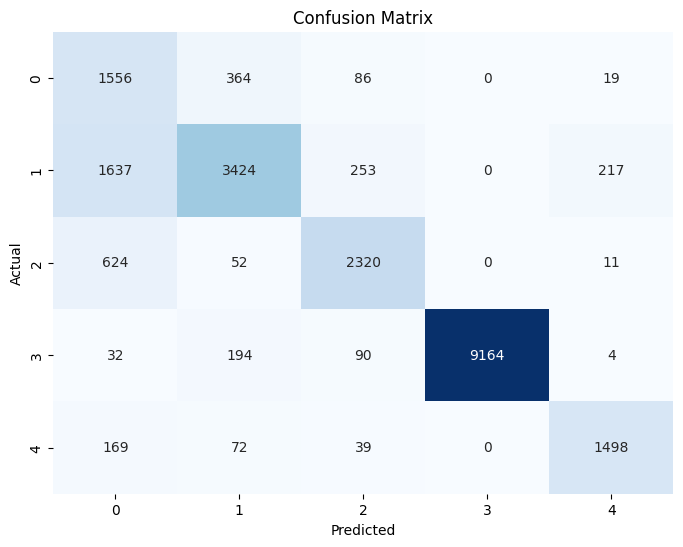

In [56]:
# Compute metrics for multi-class classification
f1 = f1_score(y_test, predictions, average='weighted')  # Macro average for multi-class
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Print metrics
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [57]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, predictions)
# Display the report
print(report)

                precision    recall  f1-score   support

           DoS       0.39      0.77      0.51      2025
      Exploits       0.83      0.62      0.71      5531
       Fuzzers       0.83      0.77      0.80      3007
       Generic       1.00      0.97      0.98      9484
Reconnaissance       0.86      0.84      0.85      1778

      accuracy                           0.82     21825
     macro avg       0.78      0.79      0.77     21825
  weighted avg       0.87      0.82      0.83     21825



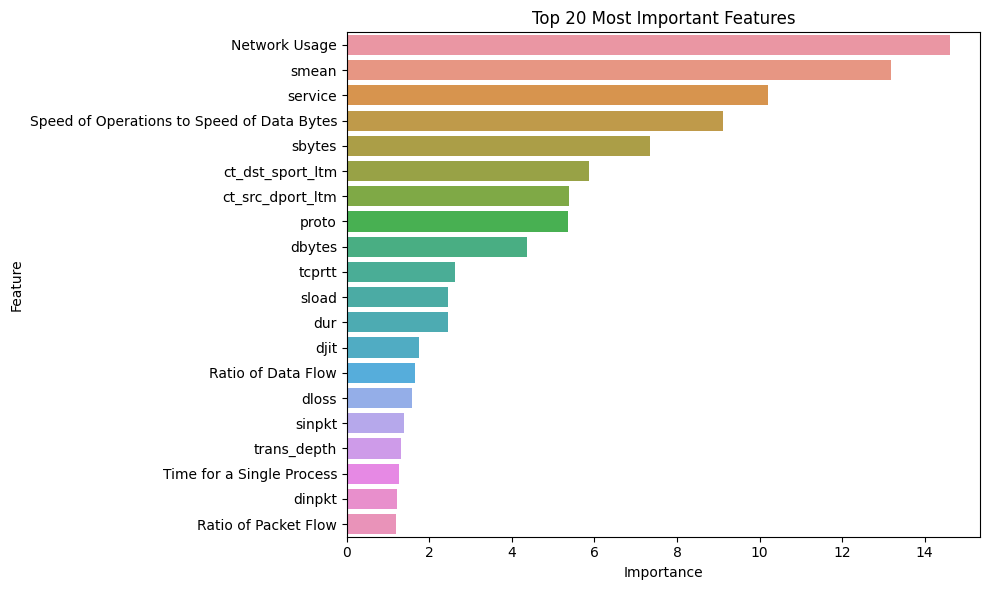

In [58]:
# Get feature importance
feature_importances = model.get_feature_importance()

# Create a DataFrame for better visualization
features_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

def plot_feature_importance(top_n=20):
    """Plots the top N important features."""

    # Select top N features
    top_features = features_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

plot_feature_importance()